In [ ]:
import math
import copy

import gym
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Linear Function Approximation

In [ ]:
class QLearning:
    def __init__(self, env, num_episodes, epsilon, lr, discount, min_eps, coding):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.lr = lr
        self.discount = discount
        self.min_eps = min_eps
        self.coding = coding

    def _init_variables(self):
        self.w = np.random.randn(self.coding.vect_len, 1)
        self.reward_list = []
        self.avg_reward_list = []

    def _get_next_action(self, state_feat):
        Q = self._get_state_action_value(state_feat)

        if np.random.random() < 1 - self.epsilon:
            action = np.argmax(Q) 
        else:
            action = np.random.randint(0, self.env.action_space.n)
        
        return action

    def _get_state_action_value(self, state_feat):
        '''
            Get state-action value for each action
        '''
        Q = []
        for i in range(self.env.action_space.n):
            Q.append(np.dot(self.coding.get_vector(state_feat, i).T, self.w))

        return np.array([Q])

    def run(self, verbose=True):
        self._init_variables()
        # error_list = []

        for i in range(self.num_episodes):
            state = self.env.reset()
            is_episode_completed = False
            total_reward = 0
            reward = 0
            # total_error = 0
            
            while is_episode_completed != True:
                state_feat = self.coding.get_features(state)              
                action = self._get_next_action(state_feat)

                next_state, reward, is_episode_completed, _ = self.env.step(action)
                next_state_feat = self.coding.get_features(next_state)

                # Terminal states
                if is_episode_completed and next_state[0] >= 0.5:
                    x = self.coding.get_vector(state_feat, action)
                    error = (reward - np.dot(x.T, self.w))
                    delta = self.lr*error*x
                    
                    self.w += delta
                
                # Update current estimates
                else:
                    x = self.coding.get_vector(state_feat, action)
                    error = (reward + 
                        self.discount*np.max(self._get_state_action_value(next_state_feat)) - 
                        np.dot(x.T, self.w)
                    )
                    delta = self.lr*error*x
                    self.w += delta

                # Update variables
                total_reward += reward
                # total_error += error**2
                state = next_state

            self.epsilon = max(self.epsilon*0.99, self.min_eps)

            self.reward_list.append(total_reward)
            # error_list.append(total_error)

            if (i+1) % 100 == 0:
                avg_reward = np.mean(self.reward_list)
                self.avg_reward_list.append(avg_reward)
                # avg_error = np.mean(error_list)
                self.reward_list = []
                # error_list = []
            
            if (i+1) % 100 == 0 and verbose:    
                print('Episode {} Average Reward: {}'.format(i+1, avg_reward))
            
        self.env.close()

In [ ]:
class SARSA:
    def __init__(self, env, num_episodes, epsilon, lr, discount, min_eps, coding):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.lr = lr
        self.discount = discount
        self.min_eps = min_eps
        self.coding = coding

    def _init_variables(self):
        self.w = np.random.randn(self.coding.vect_len, 1)
        self.reward_list = []
        self.avg_reward_list = []

    def _get_next_action(self, state_feat):
        Q = self._get_state_action_value(state_feat)

        if np.random.random() < 1 - self.epsilon:
            action = np.argmax(Q) 
        else:
            action = np.random.randint(0, self.env.action_space.n)
        
        return action

    def _get_state_action_value(self, state_feat):
        '''
            Get state-action value for each action
        '''
        Q = []
        for i in range(self.env.action_space.n):
            Q.append(np.dot(self.coding.get_vector(state_feat, i).T, self.w))

        return np.array([Q])

    def run(self, verbose=True):
        self._init_variables()

        for i in range(self.num_episodes):
            state = self.env.reset()
            is_episode_completed = False
            total_reward = 0
            reward = 0

            state_feat = self.coding.get_features(state)

            while is_episode_completed != True:
                action = self._get_next_action(state_feat)

                next_state, reward, is_episode_completed, _ = self.env.step(action)
                next_state_feat = self.coding.get_features(next_state)

                next_action = self._get_next_action(next_state_feat)

                # Terminal states
                if is_episode_completed and next_state[0] >= 0.5:
                    x = self.coding.get_vector(state_feat, action)
                    delta = self.lr*(reward - np.dot(x.T, self.w))*x
                    
                    self.w += delta
                
                # Update current estimates
                else:
                    x = self.coding.get_vector(state_feat, action)
                    y = self.coding.get_vector(next_state_feat, next_action)
                    delta = self.lr*(reward + 
                        self.discount*np.dot(y.T, self.w) - 
                        np.dot(x.T, self.w)
                    )*x
                    self.w += delta

                # Update variables
                total_reward += reward
                state_feat = next_state_feat

            self.epsilon = max(self.epsilon*0.99, self.min_eps)

            self.reward_list.append(total_reward)

            if (i+1) % 100 == 0:
                avg_reward = np.mean(self.reward_list)
                self.avg_reward_list.append(avg_reward)
                self.reward_list = []
            
            if (i+1) % 100 == 0 and verbose:    
                print('Episode {} Average Reward: {}'.format(i+1, avg_reward))
            
        self.env.close()

## Mountain Car

### Tile Coding

In [ ]:
class TileCoding:
    def __init__(self, num_tile_per_dim, env, num_tiling):
        self.num_tile_per_dim = num_tile_per_dim
        self.max_val = env.observation_space.high
        self.min_val = env.observation_space.low

        self.num_actions = env.action_space.n
        self.num_tiling = num_tiling

        self.tile_width = np.array([
            (self.max_val[i] - self.min_val[i])/self.num_tile_per_dim[i] 
            for i in range(num_tile_per_dim.shape[0])
        ])

        self.displ_vect = np.array([2*i + 1 for i in range(num_tile_per_dim.shape[0])])

        self.rate = self.displ_vect*(self.tile_width/self.num_tiling)

        self.num_tiles_per_tiling = np.prod(self.num_tile_per_dim)

        self.multiplier = [1]
        for i, num_tile in enumerate(self.num_tile_per_dim[-2::-1]):
            self.multiplier.append(self.multiplier[i]*num_tile)

        self.vect_len = self.num_tiles_per_tiling*self.num_tiling*self.num_actions

    def get_features(self, state):
        features = [(state - self.rate*i - self.min_val)/self.tile_width for i in range(self.num_tiling)]

        features = np.floor(features)
        features = features.astype(np.int32)

        return features

    def get_vector(self, features, action=None, normalize=False):  
        if action is not None:
            one_hot_vector = np.zeros((
                self.num_tiles_per_tiling*self.num_tiling*self.num_actions, 1))
            
            for i in range(self.num_tiling):
                if np.all(features[i] >= 0):
                    one_hot_vector[self.num_tiles_per_tiling * self.num_actions * i + 
                        np.sum(features[i]*list(reversed(self.multiplier))) * self.num_actions + action] = 1
        else:
            one_hot_vector = np.zeros((self.num_tiles_per_tiling*self.num_tiling, 1))
            for i in range(self.num_tiling):
                if np.all(features[i] >= 0):
                    one_hot_vector[self.num_tiles_per_tiling * i + 
                        np.sum(features[i]*list(reversed(self.multiplier)))] = 1
        
        if normalize:
            one_hot_vector /= np.linalg.norm(one_hot_vector)

        return one_hot_vector

#### Q-Learning

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(2)):
    env = gym.make('MountainCar-v0')
    env.reset()

    tile_coding = TileCoding(np.array([14, 14]), env, 7) 
    
    q_learning = QLearning(env, num_episodes = 5000, epsilon = 0.8, lr = 0.3/tile_coding.num_tiling, discount = 0.99, min_eps = 0.0, coding=tile_coding)
    q_learning.run()
    rewards.append(q_learning.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -197.35
Episode 300 Average Reward: -186.58
Episode 400 Average Reward: -172.83
Episode 500 Average Reward: -161.37
Episode 600 Average Reward: -146.24
Episode 700 Average Reward: -130.53
Episode 800 Average Reward: -136.29
Episode 900 Average Reward: -133.91
Episode 1000 Average Reward: -129.49
Episode 1100 Average Reward: -129.82
Episode 1200 Average Reward: -121.03
Episode 1300 Average Reward: -129.82
Episode 1400 Average Reward: -122.63
Episode 1500 Average Reward: -133.39
Episode 1600 Average Reward: -121.38
Episode 1700 Average Reward: -114.66
Episode 1800 Average Reward: -118.67
Episode 1900 Average Reward: -121.17
Episode 2000 Average Reward: -125.12
Episode 2100 Average Reward: -117.74
Episode 2200 Average Reward: -114.21
Episode 2300 Average Reward: -118.66
Episode 2400 Average Reward: -112.77
Episode 2500 Average Reward: -118.95
Episode 2600 Average Reward: -109.32
Episode 2700 Average Reward: -117.09
Episode 280

 50%|█████     | 1/2 [12:43<12:43, 763.25s/it]

Episode 5000 Average Reward: -112.35
Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -198.7
Episode 300 Average Reward: -185.97
Episode 400 Average Reward: -174.63
Episode 500 Average Reward: -161.6
Episode 600 Average Reward: -136.74
Episode 700 Average Reward: -138.1
Episode 800 Average Reward: -139.86
Episode 900 Average Reward: -132.99
Episode 1000 Average Reward: -133.61
Episode 1100 Average Reward: -134.91
Episode 1200 Average Reward: -127.74
Episode 1300 Average Reward: -122.73
Episode 1400 Average Reward: -124.58
Episode 1500 Average Reward: -128.55
Episode 1600 Average Reward: -125.6
Episode 1700 Average Reward: -133.5
Episode 1800 Average Reward: -133.32
Episode 1900 Average Reward: -128.68
Episode 2000 Average Reward: -118.15
Episode 2100 Average Reward: -122.34
Episode 2200 Average Reward: -122.53
Episode 2300 Average Reward: -116.94
Episode 2400 Average Reward: -121.19
Episode 2500 Average Reward: -116.21
Episode 2600 Average Reward: -123.75
Episode 2700 Ave

100%|██████████| 2/2 [25:19<00:00, 759.51s/it]

Episode 5000 Average Reward: -113.67


#### SARSA

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(2)):
    env = gym.make('MountainCar-v0')
    env.reset()

    tile_coding = TileCoding(np.array([14, 14]), env, 7) 
    
    sarsa = SARSA(env, num_episodes = 5000, epsilon = 0.8, lr = 0.3/tile_coding.num_tiling, discount = 0.99, min_eps = 0.0, coding=tile_coding)
    sarsa.run()
    rewards.append(sarsa.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -194.25
Episode 300 Average Reward: -178.63
Episode 400 Average Reward: -152.33
Episode 500 Average Reward: -153.85
Episode 600 Average Reward: -142.9
Episode 700 Average Reward: -136.1
Episode 800 Average Reward: -133.49
Episode 900 Average Reward: -142.95
Episode 1000 Average Reward: -132.24
Episode 1100 Average Reward: -135.11
Episode 1200 Average Reward: -131.92
Episode 1300 Average Reward: -129.4
Episode 1400 Average Reward: -125.03
Episode 1500 Average Reward: -130.18
Episode 1600 Average Reward: -122.37
Episode 1700 Average Reward: -122.68
Episode 1800 Average Reward: -120.52
Episode 1900 Average Reward: -118.21
Episode 2000 Average Reward: -125.97
Episode 2100 Average Reward: -121.7
Episode 2200 Average Reward: -123.12
Episode 2300 Average Reward: -121.95
Episode 2400 Average Reward: -117.24
Episode 2500 Average Reward: -117.02
Episode 2600 Average Reward: -121.5
Episode 2700 Average Reward: -115.88
Episode 2800 Ave

 50%|█████     | 1/2 [13:58<13:58, 838.57s/it]

Episode 5000 Average Reward: -113.07
Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -196.03
Episode 300 Average Reward: -175.67
Episode 400 Average Reward: -171.53
Episode 500 Average Reward: -141.67
Episode 600 Average Reward: -141.35
Episode 700 Average Reward: -129.55
Episode 800 Average Reward: -142.27
Episode 900 Average Reward: -139.07
Episode 1000 Average Reward: -134.83
Episode 1100 Average Reward: -128.21
Episode 1200 Average Reward: -129.75
Episode 1300 Average Reward: -128.7
Episode 1400 Average Reward: -117.91
Episode 1500 Average Reward: -122.48
Episode 1600 Average Reward: -119.63
Episode 1700 Average Reward: -117.73
Episode 1800 Average Reward: -125.18
Episode 1900 Average Reward: -120.97
Episode 2000 Average Reward: -120.68
Episode 2100 Average Reward: -114.56
Episode 2200 Average Reward: -121.41
Episode 2300 Average Reward: -106.72
Episode 2400 Average Reward: -116.31
Episode 2500 Average Reward: -109.63
Episode 2600 Average Reward: -117.19
Episode 2700

100%|██████████| 2/2 [27:50<00:00, 835.29s/it]

Episode 5000 Average Reward: -113.11


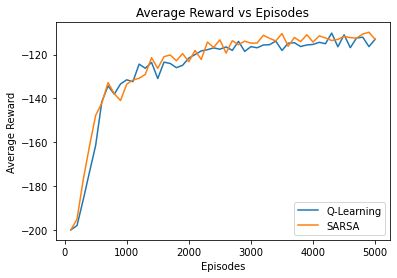

In [ ]:
rewards_qlearn = pickle.load(open('Mountaincar_tile_qlearn.sav', 'rb'))
rewards_sarsa = pickle.load(open('Mountaincar_tile_sarsa.sav', 'rb'))

rewards_qlearn = np.array(rewards_qlearn)
rewards_sarsa = np.array(rewards_sarsa)
plt.plot(100*(np.arange(len(rewards_qlearn[0])) + 1), rewards_qlearn.mean(axis=0), label='Q-Learning')
plt.plot(100*(np.arange(len(rewards_sarsa[0])) + 1), rewards_sarsa.mean(axis=0), label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Mountaincar_tile.png')
plt.show()

### Radial Basis Function Coding

In [ ]:
class RadialBasisCoding:
    def __init__(self, num_centers_per_dim, env):
        self.num_centers_per_dim = num_centers_per_dim
        self.max_val = env.observation_space.high
        self.min_val = env.observation_space.low
        
        self.num_actions = env.action_space.n

        mult = [list(range(self.num_centers_per_dim))]*self.num_centers_per_dim
        mult = np.expand_dims(mult, axis=-1)
        mult = np.concatenate([mult, mult.transpose(1, 0, -1)], axis=-1)

        self.width = (self.max_val - self.min_val)/self.num_centers_per_dim

        self.centers = (self.min_val + mult*self.width)
        self.centers = self.centers.reshape(-1, 2)
        self.centers = np.array([self.centers]*self.num_actions)
        self.centers = self.centers.reshape(-1, 2)
        ind = np.lexsort([self.centers[:, i] for i in range(self.centers.shape[-1])])
        self.centers = self.centers[ind]

        self.width /= 2
        self.width = np.mean(self.width, keepdims=True)
        self.width = self.width**2

        self.vect_len = self.centers.shape[0]

    def get_features(self, state):
        norm = np.linalg.norm(state - self.centers, axis=-1, keepdims=True)
        return np.exp(-norm/(2*self.width))

    def get_vector(self, state_features, action=None, normalize=True):
        one_hot_action = np.zeros((self.num_actions, 1))
        one_hot_action[action] = 1

        vect = np.array([one_hot_action]*self.num_centers_per_dim**self.min_val.shape[0])
        vect = vect.reshape(-1, 1)
        vect = state_features*vect

        if normalize:
            vect /= np.linalg.norm(vect)

        return vect

#### Q-Learning

In [ ]:
# np.random.seed(42)
rewards = []
for i in tqdm(range(1)):
    env = gym.make('MountainCar-v0')
    env.reset()
 
    radial_basis = RadialBasisCoding(22, env)
    
    q_learning = QLearning(env, num_episodes = 2000, epsilon = 0.8, lr = 0.05, discount = 0.99, min_eps = 0.0, coding=radial_basis)
    q_learning.run()
    rewards.append(q_learning.avg_reward_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -199.09
Episode 500 Average Reward: -198.98
Episode 600 Average Reward: -184.34
Episode 700 Average Reward: -178.11
Episode 800 Average Reward: -181.85
Episode 900 Average Reward: -172.95
Episode 1000 Average Reward: -153.04
Episode 1100 Average Reward: -166.09
Episode 1200 Average Reward: -138.69
Episode 1300 Average Reward: -143.92
Episode 1400 Average Reward: -137.71
Episode 1500 Average Reward: -130.31
Episode 1600 Average Reward: -126.14
Episode 1700 Average Reward: -135.71
Episode 1800 Average Reward: -135.14
Episode 1900 Average Reward: -144.22
Episode 2000 Average Reward: -141.49
Episode 2100 Average Reward: -126.83
Episode 2200 Average Reward: -148.4
Episode 2300 Average Reward: -173.39
Episode 2400 Average Reward: -176.42
Episode 2500 Average Reward: -168.98
Episode 2600 Average Reward: -170.07
Episode 2700 Average Reward: -170.22
Episode 2800 A

100%|██████████| 1/1 [25:11<00:00, 1511.87s/it]

Episode 5000 Average Reward: -199.81


#### SARSA

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(2)):
    env = gym.make('MountainCar-v0')
    env.reset()

    radial_basis = RadialBasisCoding(22, env)
    
    sarsa = SARSA(env, num_episodes = 2000, epsilon = 0.8, lr = 0.05, discount = 0.99, min_eps = 0.0, coding=radial_basis)
    sarsa.run()
    rewards.append(sarsa.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -199.42
Episode 400 Average Reward: -199.45
Episode 500 Average Reward: -197.48
Episode 600 Average Reward: -190.27
Episode 700 Average Reward: -187.41
Episode 800 Average Reward: -178.76
Episode 900 Average Reward: -179.63
Episode 1000 Average Reward: -168.15
Episode 1100 Average Reward: -188.43
Episode 1200 Average Reward: -176.86
Episode 1300 Average Reward: -176.01
Episode 1400 Average Reward: -182.68
Episode 1500 Average Reward: -186.66
Episode 1600 Average Reward: -196.14
Episode 1700 Average Reward: -199.07
Episode 1800 Average Reward: -198.18
Episode 1900 Average Reward: -196.28
Episode 2000 Average Reward: -193.6
Episode 2100 Average Reward: -192.16
Episode 2200 Average Reward: -189.79
Episode 2300 Average Reward: -188.46
Episode 2400 Average Reward: -184.29
Episode 2500 Average Reward: -181.55
Episode 2600 Average Reward: -180.96
Episode 2700 Average Reward: -186.16
Episode 2800 

 50%|█████     | 1/2 [28:15<28:15, 1695.29s/it]

Episode 5000 Average Reward: -161.36
Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -199.55
Episode 400 Average Reward: -197.32
Episode 500 Average Reward: -197.67
Episode 600 Average Reward: -190.16
Episode 700 Average Reward: -195.79
Episode 800 Average Reward: -188.42
Episode 900 Average Reward: -188.55
Episode 1000 Average Reward: -164.25
Episode 1100 Average Reward: -155.26
Episode 1200 Average Reward: -148.73
Episode 1300 Average Reward: -154.23
Episode 1400 Average Reward: -170.73
Episode 1500 Average Reward: -159.43
Episode 1600 Average Reward: -164.97
Episode 1700 Average Reward: -175.75
Episode 1800 Average Reward: -171.89
Episode 1900 Average Reward: -165.58
Episode 2000 Average Reward: -157.66
Episode 2100 Average Reward: -160.63
Episode 2200 Average Reward: -158.62
Episode 2300 Average Reward: -163.95
Episode 2400 Average Reward: -166.05
Episode 2500 Average Reward: -154.27
Episode 2600 Average Reward: -158.15
Episode 2700

100%|██████████| 2/2 [55:34<00:00, 1667.05s/it]

Episode 5000 Average Reward: -193.38


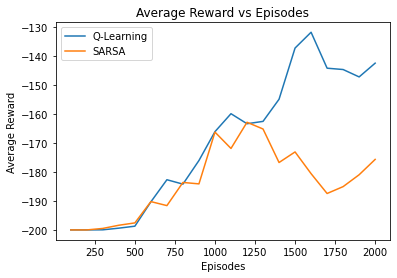

In [ ]:
rewards_qlearn = pickle.load(open('Mountaincar_radial_qlearn1.sav', 'rb'))
rewards_qlearn2 = pickle.load(open('Mountaincar_radial_qlearn2.sav', 'rb'))
rewards_sarsa = pickle.load(open('Mountaincar_radial_sarsa.sav', 'rb'))

rewards_qlearn.append(rewards_qlearn2[0])

rewards_qlearn = np.array(rewards_qlearn)
rewards_sarsa = np.array(rewards_sarsa)
plt.plot(100*(np.arange(len(rewards_qlearn[0])) + 1), rewards_qlearn.mean(axis=0), label='Q-Learning')
plt.plot(100*(np.arange(len(rewards_sarsa[0])) + 1), rewards_sarsa.mean(axis=0), label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Mountaincar_radial.png')
plt.show()

## CartPole

### Tile Coding

In [ ]:
class TileCoding:
    def __init__(self, num_tile_per_dim, env, num_tiling):
        self.num_tile_per_dim = num_tile_per_dim

        self.max_val = [3, 3.5, 0.25, 3.5]
        self.min_val = [-3, -3.5, -0.25, -3.5]

        self.num_actions = env.action_space.n
        self.num_tiling = num_tiling

        self.tile_width = np.array([
            (self.max_val[i] - self.min_val[i])/self.num_tile_per_dim[i] 
            for i in range(num_tile_per_dim.shape[0])
        ])

        self.displ_vect = np.array([2*i + 1 for i in range(num_tile_per_dim.shape[0])])

        self.rate = self.displ_vect*(self.tile_width/self.num_tiling)

        self.num_tiles_per_tiling = np.prod(self.num_tile_per_dim)

        self.multiplier = [1]
        for i, num_tile in enumerate(self.num_tile_per_dim[-2::-1]):
            self.multiplier.append(self.multiplier[i]*num_tile)

        self.vect_len = self.num_tiles_per_tiling*self.num_tiling*self.num_actions

    def get_features(self, state):
        features = [(state - self.rate*i - self.min_val)/self.tile_width for i in range(self.num_tiling)]

        features = np.floor(features)
        features = features.astype(np.int32)

        return features

    def get_vector(self, features, action=None, normalize=False):  
        if action is not None:
            one_hot_vector = np.zeros((
                self.num_tiles_per_tiling*self.num_tiling*self.num_actions, 1))
            
            for i in range(self.num_tiling):
                if np.all(features[i] >= 0):
                    one_hot_vector[self.num_tiles_per_tiling * self.num_actions * i + 
                        np.sum(features[i]*list(reversed(self.multiplier))) * self.num_actions + action] = 1
        else:
            one_hot_vector = np.zeros((self.num_tiles_per_tiling*self.num_tiling, 1))
            for i in range(self.num_tiling):
                if np.all(features[i] >= 0):
                    one_hot_vector[self.num_tiles_per_tiling * i + 
                        np.sum(features[i]*list(reversed(self.multiplier)))] = 1
        
        if normalize:
            one_hot_vector /= np.linalg.norm(one_hot_vector)

        return one_hot_vector

#### Q-Learning

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(1)):
    env = gym.make('CartPole-v0')
    env.reset()

    tile_coding = TileCoding(np.array([22, 22, 22, 22]), env, 4) 
    
    q_learning = QLearning(env, num_episodes = 1000, epsilon = 0.8, lr = 0.1/tile_coding.num_tiling, discount = 0.99, min_eps = 0.0, coding=tile_coding)
    q_learning.run()
    rewards.append(q_learning.avg_reward_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward: 26.02
Episode 200 Average Reward: 53.1
Episode 300 Average Reward: 104.64
Episode 400 Average Reward: 136.11
Episode 500 Average Reward: 166.73
Episode 600 Average Reward: 181.27
Episode 700 Average Reward: 193.2
Episode 800 Average Reward: 197.1
Episode 900 Average Reward: 198.38


100%|██████████| 1/1 [2:02:39<00:00, 7359.57s/it]

Episode 1000 Average Reward: 197.38


#### SARSA

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(2)):
    env = gym.make('CartPole-v0')
    env.reset()

    tile_coding = TileCoding(np.array([22, 22, 22, 22]), env, 4) 
    
    sarsa = SARSA(env, num_episodes = 1000, epsilon = 0.8, lr = 0.1/tile_coding.num_tiling, discount = 0.99, min_eps = 0.0, coding=tile_coding)
    sarsa.run()
    rewards.append(sarsa.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Episode 100 Average Reward: 22.92
Episode 200 Average Reward: 31.8
Episode 300 Average Reward: 64.16
Episode 400 Average Reward: 86.71
Episode 500 Average Reward: 152.48
Episode 600 Average Reward: 189.69
Episode 700 Average Reward: 192.93
Episode 800 Average Reward: 199.06
Episode 900 Average Reward: 199.75


 50%|█████     | 1/2 [1:27:15<1:27:15, 5235.08s/it]

Episode 1000 Average Reward: 199.08
Episode 100 Average Reward: 21.56
Episode 200 Average Reward: 24.0
Episode 300 Average Reward: 25.18
Episode 400 Average Reward: 45.28
Episode 500 Average Reward: 102.63
Episode 600 Average Reward: 126.48
Episode 700 Average Reward: 140.64
Episode 800 Average Reward: 152.3
Episode 900 Average Reward: 171.82


100%|██████████| 2/2 [2:30:56<00:00, 4528.33s/it]

Episode 1000 Average Reward: 181.19


(2, 10)
(2, 10)


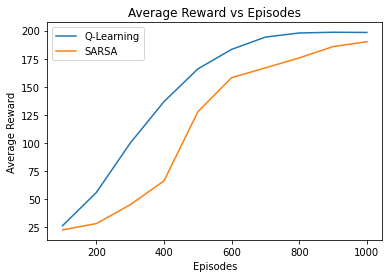

In [ ]:
rewards_qlearn = pickle.load(open('Cartpole_tile_qlearn.sav', 'rb'))
rewards_qlearn2 = pickle.load(open('Cartpole_tile_qlearn1.sav', 'rb'))
rewards_sarsa = pickle.load(open('Cartpole_tile_sarsa.sav', 'rb'))

rewards_qlearn.append(rewards_qlearn2[0])

rewards_qlearn = np.array(rewards_qlearn)
print(rewards_qlearn.shape)
rewards_sarsa = np.array(rewards_sarsa)
print(rewards_sarsa.shape)
plt.plot(100*(np.arange(len(rewards_qlearn[0])) + 1), rewards_qlearn.mean(axis=0), label='Q-Learning')
plt.plot(100*(np.arange(len(rewards_sarsa[0])) + 1), rewards_sarsa.mean(axis=0), label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Cartpole_tile.png')
plt.show()

###Radial Basis Function Coding

In [ ]:
class RadialBasisCoding:
    def __init__(self, num_centers_per_dim, env):
        self.num_centers_per_dim = num_centers_per_dim

        self.max_val = np.array([3, 3.5, 0.25, 3.5])
        self.min_val = np.array([-3, -3.5, -0.25, -3.5])

        self.num_actions = env.action_space.n

        self.width = (self.max_val - self.min_val)/self.num_centers_per_dim

        centers = []
        for i in range(self.num_centers_per_dim):
            for j in range(self.num_centers_per_dim):
                for k in range(self.num_centers_per_dim):
                    for l in range(self.num_centers_per_dim):
                        centers.append([
                            self.min_val[0] + i*self.width[0],
                            self.min_val[1] + j*self.width[1],
                            self.min_val[2] + k*self.width[2],
                            self.min_val[3] + l*self.width[3]
                        ])
        self.centers = np.array(centers)
        print(self.centers.shape)

        self.centers = np.array([self.centers]*self.num_actions)
        self.centers = self.centers.reshape(-1, self.centers.shape[-1])
        ind = np.lexsort([self.centers[:, i] for i in range(self.centers.shape[-1])])
        self.centers = self.centers[ind]

        self.width /= 2
        self.width = np.mean(self.width, keepdims=True)
        self.width = self.width**2

        self.vect_len = self.centers.shape[0]


    def get_features(self, state):
        norm = np.linalg.norm(state - self.centers, axis=-1, keepdims=True)
        return np.exp(-norm/(2*self.width))

    def get_vector(self, state_features, action=None, normalize=True):
        one_hot_action = np.zeros((self.num_actions, 1))
        one_hot_action[action] = 1

        vect = np.array([one_hot_action]*self.num_centers_per_dim**self.min_val.shape[0])
        vect = vect.reshape(-1, 1)
        vect = state_features*vect

        if normalize:
            vect /= np.linalg.norm(vect)

        return vect

#### Q-Learning

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(2)):
    env = gym.make('CartPole-v0')
    env.reset()
 
    radial_basis = RadialBasisCoding(15, env)
    
    q_learning = QLearning(env, num_episodes = 1000, epsilon = 0.8, lr = 0.1, discount = 0.99, min_eps = 0.0, coding=radial_basis)
    q_learning.run()
    rewards.append(q_learning.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

(50625, 4)
Total Episodic Reward: 18.0Episode 100 Average Reward: 23.15
Total Episodic Reward: 12.0Episode 200 Average Reward: 20.27
Total Episodic Reward: 43.0Episode 300 Average Reward: 42.49
Total Episodic Reward: 106.0Episode 400 Average Reward: 53.26
Total Episodic Reward: 200.0Episode 500 Average Reward: 129.98
Total Episodic Reward: 86.0Episode 600 Average Reward: 130.48
Total Episodic Reward: 78.0Episode 700 Average Reward: 147.99
Total Episodic Reward: 200.0Episode 800 Average Reward: 145.06
Total Episodic Reward: 200.0Episode 900 Average Reward: 151.14
Total Episodic Reward: 200.0

 50%|█████     | 1/2 [5:51:49<5:51:49, 21109.36s/it]

Total Episodic Reward: 103.0Episode 1000 Average Reward: 151.39
(50625, 4)
Total Episodic Reward: 28.0

 50%|█████     | 1/2 [5:54:56<5:54:56, 21296.06s/it]


KeyboardInterrupt: ignored

####SARSA

In [ ]:
np.random.seed(42)
rewards = []
for i in tqdm(range(1)):
    env = gym.make('CartPole-v0')
    env.reset()
 
    radial_basis = RadialBasisCoding(15, env)

    sarsa = SARSA(env, num_episodes = 1000, epsilon = 0.8, lr = 0.1, discount = 0.99, min_eps = 0.0, coding=radial_basis)
    sarsa.run()
    rewards.append(sarsa.avg_reward_list) 

  0%|          | 0/1 [00:00<?, ?it/s]

(50625, 4)
Episode 100 Average Reward: 35.42
Episode 200 Average Reward: 35.01
Episode 300 Average Reward: 35.38
Episode 400 Average Reward: 36.48
Episode 500 Average Reward: 81.09
Episode 600 Average Reward: 85.58
Episode 700 Average Reward: 121.45
Episode 800 Average Reward: 155.65
Episode 900 Average Reward: 150.38


100%|██████████| 1/1 [5:55:11<00:00, 21311.57s/it]

Episode 1000 Average Reward: 153.55


(1, 10)
(1, 10)


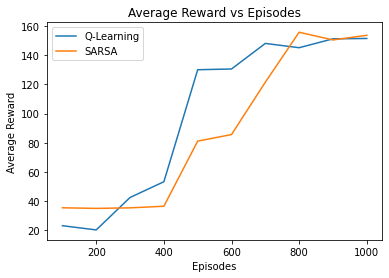

In [ ]:
rewards_qlearn = pickle.load(open('Cartpole_radial_qlearn.sav', 'rb'))
rewards_sarsa = pickle.load(open('Cartpole_radial_sarsa.sav', 'rb'))

rewards_qlearn = np.array(rewards_qlearn)
print(rewards_qlearn.shape)
rewards_sarsa = np.array(rewards_sarsa)
print(rewards_sarsa.shape)
plt.plot(100*(np.arange(len(rewards_qlearn[0])) + 1), rewards_qlearn.mean(axis=0), label='Q-Learning')
plt.plot(100*(np.arange(len(rewards_sarsa[0])) + 1), rewards_sarsa.mean(axis=0), label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Cartpole_radial.png')
plt.show()

# REINFORCE Algorithm

In [ ]:
class Reinforce:
    def __init__(self, env, lr, num_episodes, discount, device='cpu'):
        self.env = env
        self.lr = lr
        self.num_episodes = num_episodes
        self.discount = discount

        state_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n

        self.policy = Policy(
            state_dim = env.observation_space.shape[0],
            hidden_units = 16,
            action_dim = env.action_space.n,
            device = device
        ).to(device)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.reward_list = []
        self.avg_reward_list = []

    def run(self, verbose=True):
        for i in range(self.num_episodes):
            log_probs = []
            rewards = []
            state = env.reset()
            done = False

            while not done:
                action, log_prob = self.policy.act(state)
                state, reward, done, _ = env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)

            self.reward_list.append(sum(rewards))

            discounts = [self.discount**i for i in range(len(rewards)+1)]
            R = sum([a*b for a,b in zip(discounts, rewards)])

            policy_loss = []
            for log_prob in log_probs:
                policy_loss.append(-log_prob * R)
            policy_loss = torch.cat(policy_loss).sum()

            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

            if (i+1) % 100 == 0:
                avg_reward = np.mean(self.reward_list)
                self.avg_reward_list.append(avg_reward)
                self.reward_list = []
            
            if (i+1) % 100 == 0 and verbose:    
                print('Episode {} Average Reward: {}'.format(i+1, avg_reward))

        self.env.close()

In [ ]:
class ReinforceWithLowVariance:
    def __init__(self, env, lr, num_episodes, discount, device='cpu'):
        self.env = env
        self.lr = lr
        self.num_episodes = num_episodes
        self.discount = discount

        state_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n

        self.policy = Policy(
            state_dim = env.observation_space.shape[0],
            hidden_units = 16,
            action_dim = env.action_space.n,
            device = device
        ).to(device)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.reward_list = []
        self.avg_reward_list = []

    def run(self, verbose=True):
        for i in range(self.num_episodes):
            log_probs = []
            rewards = []
            state = env.reset()
            done = False

            while not done:
                action, log_prob = self.policy.act(state)
                state, reward, done, _ = env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)

            self.reward_list.append(sum(rewards))

            discounts = [self.discount**i for i in range(len(rewards)+1)]
            R = sum([a*b for a,b in zip(discounts, rewards)])

            # Return Calculation
            G = copy.deepcopy(list(rewards))
            for j in reversed(range(len(rewards)-1)):
                G[j] += self.discount*G[j+1]

            policy_loss = []
            for log_prob, G_t in zip(log_probs, G):
                policy_loss.append(-log_prob * G_t)
            policy_loss = torch.cat(policy_loss).sum()

            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

            if (i+1) % 100 == 0:
                avg_reward = np.mean(self.reward_list)
                self.avg_reward_list.append(avg_reward)
                self.reward_list = []
            
            if (i+1) % 100 == 0 and verbose:    
                print('Episode {} Average Reward: {}'.format(i+1, avg_reward))

        self.env.close()

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim=2, hidden_units=16, action_dim=3, device='cpu'):
        super(Policy, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, action_dim)

        self.device = device

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.forward(state).cpu()
        m = torch.distributions.Categorical(probs=probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

##Mountain Car

### REINFORCE Version 1

In [ ]:
torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards = []

for i in tqdm(range(1)):
    env = gym.make('MountainCar-v0')
    # env.seed(0)
    env.reset()

    reinforce = Reinforce(env, lr=1e-2, num_episodes=5000, discount=0.99, device=device)
    reinforce.run()
    rewards.append(reinforce.avg_reward_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -200.0
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0
E

100%|██████████| 1/1 [24:24<00:00, 1464.42s/it]

Episode 5000 Average Reward: -200.0


In [ ]:
torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards = []

for i in tqdm(range(1)):
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    # env.seed(0)
    env.reset()

    reinforce = Reinforce(env, lr=1e-2, num_episodes=5000, discount=0.99, device=device)
    reinforce.run()
    rewards.append(reinforce.avg_reward_list)

Episode 100	Average Score: -1000.00
Episode 200	Average Score: -1000.00
Episode 300	Average Score: -1000.00
Episode 400	Average Score: -1000.00
Episode 500	Average Score: -1000.00
Episode 600	Average Score: -1000.00
Episode 700	Average Score: -1000.00
Episode 800	Average Score: -1000.00
Episode 900	Average Score: -1000.00
Episode 1000	Average Score: -1000.00
Episode 1100	Average Score: -1000.00
Episode 1200	Average Score: -1000.00
Episode 1300	Average Score: -1000.00
Episode 1400	Average Score: -1000.00
Episode 1500	Average Score: -1000.00
Episode 1600	Average Score: -1000.00
Episode 1700	Average Score: -1000.00
Episode 1800	Average Score: -1000.00
Episode 1900	Average Score: -1000.00
Episode 2000	Average Score: -1000.00
Episode 2100	Average Score: -1000.00
Episode 2200	Average Score: -1000.00
Episode 2300	Average Score: -1000.00
Episode 2400	Average Score: -1000.00
Episode 2500	Average Score: -1000.00
Episode 2600	Average Score: -1000.00
Episode 2700	Average Score: -1000.00
Episode 28

KeyboardInterrupt: ignored

### REINFORCE Version 2

In [ ]:
torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards = []

for i in tqdm(range(1)):
    env = gym.make('MountainCar-v0')
    # env.seed(0)
    env.reset()

    reinforce = ReinforceWithLowVariance(env, lr=1e-2, num_episodes=5000, discount=0.99, device=device)
    reinforce.run()
    rewards.append(reinforce.avg_reward_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -200.0
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0
E

100%|██████████| 1/1 [21:23<00:00, 1283.55s/it]

Episode 5000 Average Reward: -200.0


## CartPole

### REINFORCE Version 1

In [ ]:
torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards = []

for i in tqdm(range(1)):
    env = gym.make('CartPole-v0')
    env.reset()

    reinforce = Reinforce(env, lr=1e-2, num_episodes=5000, discount=0.99, device=device)
    reinforce.run()
    rewards.append(reinforce.avg_reward_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Episode 100 Average Reward: 18.44
Episode 200 Average Reward: 57.23
Episode 300 Average Reward: 66.76
Episode 400 Average Reward: 88.97
Episode 500 Average Reward: 95.6
Episode 600 Average Reward: 86.75
Episode 700 Average Reward: 56.73
Episode 800 Average Reward: 104.8
Episode 900 Average Reward: 74.53
Episode 1000 Average Reward: 107.15
Episode 1100 Average Reward: 159.66
Episode 1200 Average Reward: 175.01
Episode 1300 Average Reward: 44.1
Episode 1400 Average Reward: 90.04
Episode 1500 Average Reward: 52.13
Episode 1600 Average Reward: 94.95
Episode 1700 Average Reward: 160.32
Episode 1800 Average Reward: 76.69
Episode 1900 Average Reward: 53.6
Episode 2000 Average Reward: 53.07
Episode 2100 Average Reward: 49.96
Episode 2200 Average Reward: 47.47
Episode 2300 Average Reward: 62.56
Episode 2400 Average Reward: 77.25
Episode 2500 Average Reward: 131.17
Episode 2600 Average Reward: 146.48
Episode 2700 Average Reward: 60.9
Episode 2800 Average Reward: 66.48
Episode 2900 Average Reward

100%|██████████| 1/1 [10:07<00:00, 607.65s/it]

Episode 5000 Average Reward: 200.0


### REINFORCE Version 2

In [ ]:
torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rewards = []

for i in tqdm(range(2)):
    env = gym.make('CartPole-v0')
    env.reset()

    reinforce = ReinforceWithLowVariance(env, lr=1e-2, num_episodes=5000, discount=0.99, device=device)
    reinforce.run()
    rewards.append(reinforce.avg_reward_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Episode 100 Average Reward: 101.67
Episode 200 Average Reward: 178.8
Episode 300 Average Reward: 195.36
Episode 400 Average Reward: 189.08
Episode 500 Average Reward: 178.54
Episode 600 Average Reward: 187.36
Episode 700 Average Reward: 177.11
Episode 800 Average Reward: 193.23
Episode 900 Average Reward: 199.97
Episode 1000 Average Reward: 190.11
Episode 1100 Average Reward: 195.07
Episode 1200 Average Reward: 169.79
Episode 1300 Average Reward: 114.85
Episode 1400 Average Reward: 183.8
Episode 1500 Average Reward: 199.89
Episode 1600 Average Reward: 150.01
Episode 1700 Average Reward: 197.61
Episode 1800 Average Reward: 199.68
Episode 1900 Average Reward: 198.07
Episode 2000 Average Reward: 139.55
Episode 2100 Average Reward: 110.27
Episode 2200 Average Reward: 104.62
Episode 2300 Average Reward: 121.13
Episode 2400 Average Reward: 130.71
Episode 2500 Average Reward: 149.95
Episode 2600 Average Reward: 107.24
Episode 2700 Average Reward: 85.62
Episode 2800 Average Reward: 75.62
Episo

 50%|█████     | 1/2 [15:33<15:33, 933.62s/it]

Episode 5000 Average Reward: 131.43
Episode 100 Average Reward: 41.08
Episode 200 Average Reward: 139.5
Episode 300 Average Reward: 139.79
Episode 400 Average Reward: 190.09
Episode 500 Average Reward: 200.0
Episode 600 Average Reward: 200.0
Episode 700 Average Reward: 191.53
Episode 800 Average Reward: 189.74
Episode 900 Average Reward: 187.64
Episode 1000 Average Reward: 200.0
Episode 1100 Average Reward: 195.27
Episode 1200 Average Reward: 199.14
Episode 1300 Average Reward: 121.8
Episode 1400 Average Reward: 102.62
Episode 1500 Average Reward: 127.66
Episode 1600 Average Reward: 117.39
Episode 1700 Average Reward: 103.28
Episode 1800 Average Reward: 142.1
Episode 1900 Average Reward: 124.9
Episode 2000 Average Reward: 94.28
Episode 2100 Average Reward: 111.25
Episode 2200 Average Reward: 78.41
Episode 2300 Average Reward: 91.42
Episode 2400 Average Reward: 68.8
Episode 2500 Average Reward: 89.96
Episode 2600 Average Reward: 155.18
Episode 2700 Average Reward: 195.96
Episode 2800 Av

100%|██████████| 2/2 [31:45<00:00, 953.00s/it]

Episode 5000 Average Reward: 195.14


(2, 50)
(2, 50)


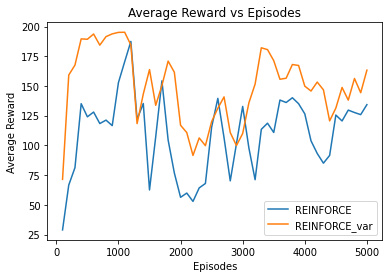

In [ ]:
rewards_reinforce = pickle.load(open('Cartpole_reinforce.sav', 'rb'))
rewards_reinforce_var = pickle.load(open('Cartpole_reinforce_variance.sav', 'rb'))

rewards_reinforce = np.array(rewards_reinforce)
print(rewards_reinforce.shape)
rewards_reinforce_var = np.array(rewards_reinforce_var)
print(rewards_reinforce_var.shape)
plt.plot(100*(np.arange(len(rewards_reinforce[0])) + 1), rewards_reinforce.mean(axis=0), label='REINFORCE')
plt.plot(100*(np.arange(len(rewards_reinforce_var[0])) + 1), rewards_reinforce_var.mean(axis=0), label='REINFORCE_var')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Cartpole_reinforce.png')
plt.show()

# Deep Reinforcement Learning

## Advantage Actor Critic (A2C)

In [ ]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [ ]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [ ]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [ ]:
class A2C:
    def __init__(self, num_episodes, env, lr, discount):
        self.num_episodes = num_episodes
        self.env = env
        self.discount = discount
        self.lr = lr

        state_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n
        self.actor = Actor(state_dim, n_actions)
        self.critic = Critic(state_dim)

        self.adam_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.adam_critic = torch.optim.Adam(self.critic.parameters(), lr=lr)

        self.episode_rewards = []
        self.avg_reward_list = []

    def run(self, verbose=True):

        for i in tqdm(range(self.num_episodes)):
            done = False
            total_reward = 0
            state = self.env.reset()

            while not done:
                probs = self.actor(t(state))
                dist = torch.distributions.Categorical(probs=probs)
                action = dist.sample()
                
                next_state, reward, done, info = self.env.step(action.detach().data.numpy())
                advantage = reward + (1-done)*self.discount*self.critic(t(next_state)) - self.critic(t(state))
                
                total_reward += reward
                state = next_state

                critic_loss = advantage.pow(2).mean()
                self.adam_critic.zero_grad()
                critic_loss.backward()
                self.adam_critic.step()

                actor_loss = -dist.log_prob(action)*advantage.detach()
                self.adam_actor.zero_grad()
                actor_loss.backward()
                self.adam_actor.step()
                    
            self.episode_rewards.append(total_reward)

            if (i+1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards)
                self.avg_reward_list.append(avg_reward)
                self.episode_rewards = []
                    
            if (i+1) % 100 == 0 and verbose:    
                print('Episode {} Average Reward: {}'.format(i+1, avg_reward))

            if (i+1) % 1000 == 0:
                self.lr *= 0.9
                for param_group in self.adam_actor.param_groups:
                    param_group['lr'] = self.lr

                for param_group in self.adam_critic.param_groups:
                    param_group['lr'] = self.lr

In [ ]:
rewards = []
for i in range(1):
    env = gym.make("CartPole-v0")
    env.reset()

    a2c = A2C(num_episodes=5000, env=env, lr=1e-3, discount=0.99)
    a2c.run()
    rewards.append(a2c.avg_reward_list)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  2%|▏         | 101/5000 [00:12<12:54,  6.33it/s]

Episode 100 Average Reward: 38.12


  4%|▍         | 200/5000 [00:37<23:30,  3.40it/s]

Episode 200 Average Reward: 77.4


  6%|▌         | 300/5000 [01:19<49:24,  1.59it/s]

Episode 300 Average Reward: 129.8


  8%|▊         | 400/5000 [02:08<33:01,  2.32it/s]

Episode 400 Average Reward: 151.61


 10%|█         | 500/5000 [02:52<09:07,  8.22it/s]

Episode 500 Average Reward: 136.38


 12%|█▏        | 600/5000 [03:42<36:33,  2.01it/s]

Episode 600 Average Reward: 150.46


 14%|█▍        | 700/5000 [04:20<34:03,  2.10it/s]

Episode 700 Average Reward: 111.03


 16%|█▌        | 800/5000 [05:14<32:42,  2.14it/s]

Episode 800 Average Reward: 155.29


 18%|█▊        | 900/5000 [05:47<23:54,  2.86it/s]

Episode 900 Average Reward: 91.43


 20%|██        | 1000/5000 [06:51<45:45,  1.46it/s]

Episode 1000 Average Reward: 175.81


 22%|██▏       | 1100/5000 [07:55<39:20,  1.65it/s]

Episode 1100 Average Reward: 177.49


 24%|██▍       | 1200/5000 [09:02<36:40,  1.73it/s]

Episode 1200 Average Reward: 181.18


 26%|██▌       | 1300/5000 [09:44<33:27,  1.84it/s]

Episode 1300 Average Reward: 111.78


 28%|██▊       | 1400/5000 [10:29<35:51,  1.67it/s]

Episode 1400 Average Reward: 120.18


 30%|███       | 1500/5000 [11:14<33:03,  1.76it/s]

Episode 1500 Average Reward: 121.03


 32%|███▏      | 1600/5000 [11:59<33:41,  1.68it/s]

Episode 1600 Average Reward: 120.08


 34%|███▍      | 1700/5000 [12:48<28:37,  1.92it/s]

Episode 1700 Average Reward: 134.59


 36%|███▌      | 1800/5000 [13:30<22:28,  2.37it/s]

Episode 1800 Average Reward: 109.51


 38%|███▊      | 1900/5000 [14:05<15:09,  3.41it/s]

Episode 1900 Average Reward: 92.62


 40%|████      | 2000/5000 [14:41<19:04,  2.62it/s]

Episode 2000 Average Reward: 97.26


 42%|████▏     | 2100/5000 [15:23<19:33,  2.47it/s]

Episode 2100 Average Reward: 112.18


 44%|████▍     | 2201/5000 [16:01<12:05,  3.86it/s]

Episode 2200 Average Reward: 98.77


 46%|████▌     | 2300/5000 [16:25<10:40,  4.22it/s]

Episode 2300 Average Reward: 65.82


 48%|████▊     | 2400/5000 [16:51<07:49,  5.54it/s]

Episode 2400 Average Reward: 66.83


 50%|█████     | 2500/5000 [17:15<07:56,  5.25it/s]

Episode 2500 Average Reward: 62.22


 52%|█████▏    | 2600/5000 [17:41<10:39,  3.76it/s]

Episode 2600 Average Reward: 70.13


 54%|█████▍    | 2700/5000 [18:24<12:14,  3.13it/s]

Episode 2700 Average Reward: 112.43


 56%|█████▌    | 2800/5000 [18:50<07:41,  4.77it/s]

Episode 2800 Average Reward: 70.72


 58%|█████▊    | 2901/5000 [19:25<06:41,  5.23it/s]

Episode 2900 Average Reward: 91.74


 60%|██████    | 3000/5000 [19:55<11:14,  2.97it/s]

Episode 3000 Average Reward: 78.62


 62%|██████▏   | 3100/5000 [20:25<09:46,  3.24it/s]

Episode 3100 Average Reward: 76.62


 64%|██████▍   | 3201/5000 [20:56<05:29,  5.47it/s]

Episode 3200 Average Reward: 81.68


 66%|██████▌   | 3300/5000 [21:18<06:53,  4.11it/s]

Episode 3300 Average Reward: 56.1


 68%|██████▊   | 3400/5000 [21:46<09:14,  2.88it/s]

Episode 3400 Average Reward: 74.02


 70%|███████   | 3500/5000 [22:16<04:38,  5.38it/s]

Episode 3500 Average Reward: 77.77


 72%|███████▏  | 3600/5000 [22:47<05:20,  4.37it/s]

Episode 3600 Average Reward: 81.01


 74%|███████▍  | 3702/5000 [23:21<02:23,  9.07it/s]

Episode 3700 Average Reward: 88.74


 76%|███████▌  | 3800/5000 [23:44<05:08,  3.89it/s]

Episode 3800 Average Reward: 60.46


 78%|███████▊  | 3900/5000 [24:12<06:27,  2.84it/s]

Episode 3900 Average Reward: 71.42


 80%|████████  | 4000/5000 [24:39<05:55,  2.81it/s]

Episode 4000 Average Reward: 69.82


 82%|████████▏ | 4100/5000 [25:09<02:37,  5.70it/s]

Episode 4100 Average Reward: 80.76


 84%|████████▍ | 4200/5000 [25:45<04:21,  3.06it/s]

Episode 4200 Average Reward: 92.68


 86%|████████▌ | 4300/5000 [26:15<03:22,  3.46it/s]

Episode 4300 Average Reward: 78.24


 88%|████████▊ | 4401/5000 [26:43<02:20,  4.25it/s]

Episode 4400 Average Reward: 72.01


 90%|█████████ | 4500/5000 [27:13<04:01,  2.07it/s]

Episode 4500 Average Reward: 80.25


 92%|█████████▏| 4600/5000 [27:48<01:54,  3.50it/s]

Episode 4600 Average Reward: 91.62


 94%|█████████▍| 4700/5000 [28:20<00:57,  5.26it/s]

Episode 4700 Average Reward: 80.11


 96%|█████████▌| 4800/5000 [28:47<00:53,  3.76it/s]

Episode 4800 Average Reward: 71.38


 98%|█████████▊| 4905/5000 [28:55<00:03, 26.93it/s]

Episode 4900 Average Reward: 18.71


100%|██████████| 5000/5000 [28:59<00:00,  2.88it/s]

Episode 5000 Average Reward: 9.47


(1, 50)


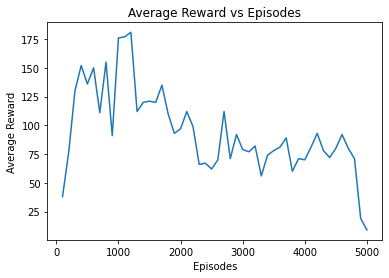

In [ ]:
rewards = np.array(rewards)
print(rewards.shape)
plt.plot(100*(np.arange(len(rewards[0])) + 1), np.round(rewards.mean(axis=0), 0))
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
# plt.savefig('A2C_Cartpole.png')
plt.show()

In [ ]:
pickle.dump(rewards, open('A2C_cartpole1.sav', 'wb'))


## Deep Q-Network (DQN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
import gym

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

env = gym.make("CartPole-v0")
env.seed(0)
agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0)

In [ ]:
def dqn(n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=200.0:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

    return scores

scores = dqn()

Episode 100	Average Score: 16.91
Episode 200	Average Score: 12.41
Episode 300	Average Score: 11.05
Episode 400	Average Score: 10.32
Episode 500	Average Score: 9.88
Episode 600	Average Score: 9.77
Episode 700	Average Score: 9.93
Episode 800	Average Score: 11.20
Episode 900	Average Score: 14.18
Episode 1000	Average Score: 77.95
Episode 1100	Average Score: 183.51
Episode 1200	Average Score: 185.66
Episode 1300	Average Score: 186.70
Episode 1400	Average Score: 179.88
Episode 1500	Average Score: 182.71
Episode 1600	Average Score: 188.82
Episode 1700	Average Score: 192.42
Episode 1800	Average Score: 185.13
Episode 1900	Average Score: 165.81
Episode 2000	Average Score: 151.84
Episode 2100	Average Score: 149.11
Episode 2200	Average Score: 145.98
Episode 2300	Average Score: 143.12
Episode 2400	Average Score: 152.27
Episode 2500	Average Score: 150.45
Episode 2600	Average Score: 172.99
Episode 2700	Average Score: 166.16
Episode 2800	Average Score: 179.73
Episode 2900	Average Score: 177.74
Episode

(1, 50)
(1, 50)


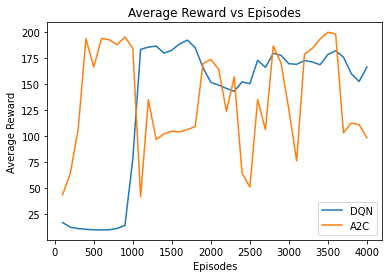

In [ ]:
rewards_a2c = pickle.load(open('A2C_cartpole.sav', 'rb'))
rewards_dqn = pickle.load(open('DQN_cartpole.sav', 'rb'))

avg_rewards_dqn = []
for i in range(0, 5000, 100):
    avg_rewards_dqn.append(np.mean(rewards_dqn[i:i+100]))
rewards_dqn = [avg_rewards_dqn]

rewards_dqn = np.array(rewards_dqn)
print(rewards_dqn.shape)
rewards_a2c = np.array(rewards_a2c)
print(rewards_a2c.shape)
plt.plot(100*(np.arange(len(rewards_dqn[0])) + 1), rewards_dqn.mean(axis=0), label='DQN')
plt.plot(100*(np.arange(len(rewards_a2c[0])) + 1), rewards_a2c.mean(axis=0), label='A2C')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.legend()
plt.savefig('Cartpole_deeprl.png')
plt.show()